### Extract the dataset and split accordingly

- Unzip the dataset
- Split the dataset into train, validation and test sets
- From the metadata build the train, validation and test images and labels folders
- Load the Images from directory

In [167]:
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import helper_funcs as helper
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from pathlib import Path


import warnings
warnings.filterwarnings('ignore')

# model analysis and development
import edgeimpulse as ei
from livelossplot import PlotLossesKeras 

# Import the necessary callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from livelossplot.outputs import MatplotlibPlot
from plot_keras_history import  plot_history


# Set random seed for reproducibility
random_state = 42
tf.random.set_seed(random_state)
# random.seed(random_state)

In [ ]:
# Extract the dataset to the current working directory
with zipfile.ZipFile('./dataset.zip', 'r') as zip:
    zip.extractall(f'{os.getcwd()}')

In [2]:
# load the train and test metadata
data_dir = os.path.join(os.getcwd(), 'dataset')
train_metadata_path = os.path.join(data_dir, 'train.csv')
test_metadata_path = os.path.join(data_dir, 'test.csv')

# read the data
train_df = pd.read_csv(train_metadata_path)
test_df = pd.read_csv(test_metadata_path)

# split the train set to train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# the length of all the sets
sets_len = len(train_df) + len(val_df) + len(test_df)

# print the length of each set
print(f'Train set length: {len(train_df)}, {len(train_df)/sets_len*100:.2f}%')
print(f'Validation set length: {len(val_df)}, {len(val_df)/sets_len*100:.2f}%')
print(f'Test set length: {len(test_df)}, {len(test_df)/sets_len*100:.2f}%')

Train set length: 1668, 71.83%
Validation set length: 418, 18.00%
Test set length: 236, 10.16%


In [ ]:
# build the image datasets
train_dir = os.path.join(data_dir, 'train') # location of the training data
val_dir = os.path.join(data_dir, 'train') # location of the validation data
test_dir = os.path.join(data_dir, 'test') # location of the test data

# create the training, validation and test directories
helper.split_data(train_dir, train_df, 'train')
helper.split_data(val_dir, val_df, 'val')
helper.split_data(test_dir, test_df, 'test')

In [23]:
# load the images to tensors 
train_images_path = 'train'
val_images_path = 'val'
test_images_path = 'test'

train_tensors = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    'train',
                                                                    image_size=(96, 96),
                                                                    batch_size=9,
                                                                    shuffle=True
                                                                )
val_tensors = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    'val',
                                                                    image_size=(96, 96),
                                                                    batch_size=9
                                                                )
test_tensors = tf.keras.preprocessing.image_dataset_from_directory(
                                                                    'test',
                                                                    image_size=(96, 96),
                                                                    batch_size=9
                                                                )

# extract the train images and labels
train_images, train_labels = helper.extract_images_and_labels(train_tensors, normalize=True, categorical=True)

# extract the validation images and labels
val_images, val_labels = helper.extract_images_and_labels(val_tensors, normalize=True, categorical=True)

# extract the test images and labels
test_images, test_labels = helper.extract_images_and_labels(test_tensors, normalize=True, categorical=False)

# Define the labels dictionary
labels = {
    0: 'BUSHBUCK',
    1: 'IMPALA',
    2: 'MONKEY',
    3: 'WARTHOG',
    4: 'WATERBUCK',
    5: 'ZEBRA'
}



Found 1668 files belonging to 6 classes.
Found 418 files belonging to 6 classes.
Found 236 files belonging to 6 classes.


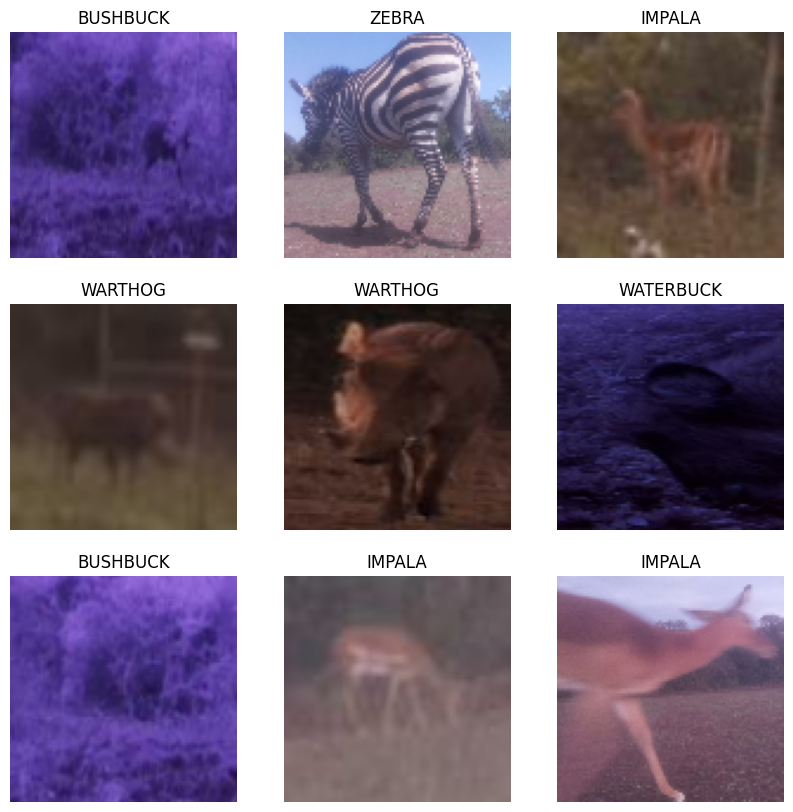

In [17]:
helper.visualize_images(train_tensors)

In [19]:
helper.data_distribution(train_images_path, val_images_path, test_images_path, plot=False)

({'BUSHBUCK': 153,
  'IMPALA': 628,
  'MONKEY': 14,
  'WARTHOG': 484,
  'WATERBUCK': 264,
  'ZEBRA': 125},
 {'BUSHBUCK': 31,
  'IMPALA': 186,
  'MONKEY': 8,
  'WARTHOG': 101,
  'WATERBUCK': 61,
  'ZEBRA': 31},
 {'BUSHBUCK': 21,
  'IMPALA': 91,
  'MONKEY': 3,
  'WARTHOG': 66,
  'WATERBUCK': 37,
  'ZEBRA': 18})

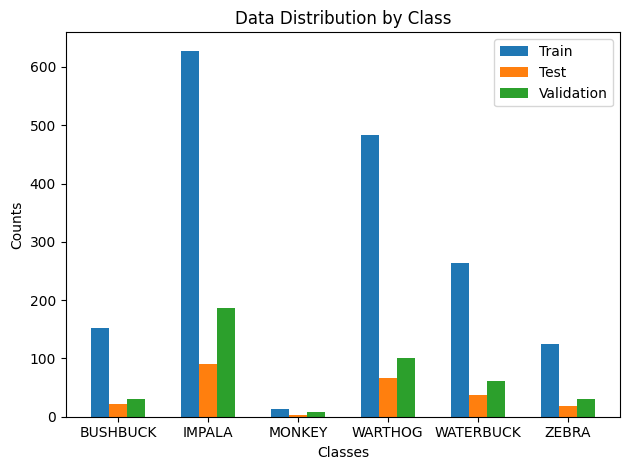

In [20]:
helper.data_distribution(train_images_path, val_images_path, test_images_path, plot=True)

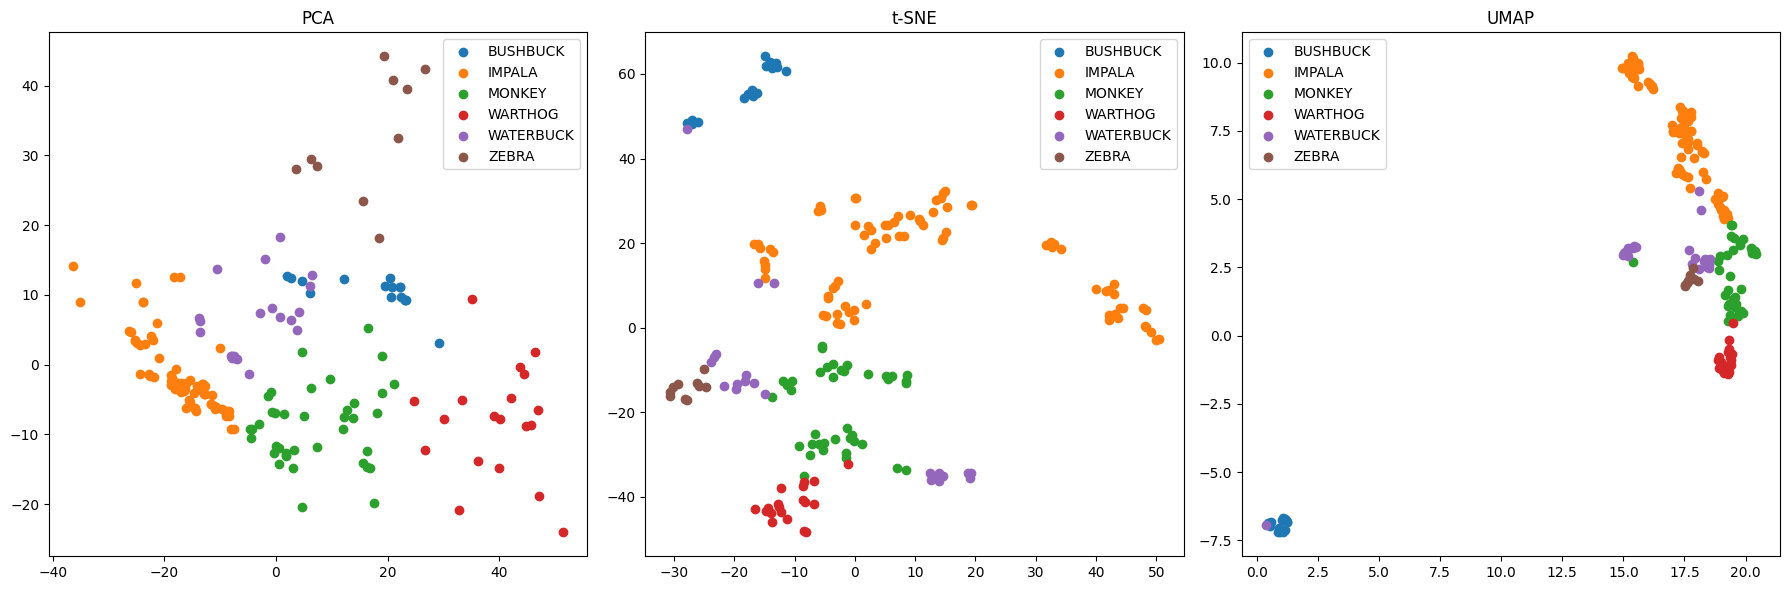

In [21]:
# Call the function with your train_images, train_labels, and labels
helper.visualize_dimensionality_reduction(train_images, train_labels, labels)


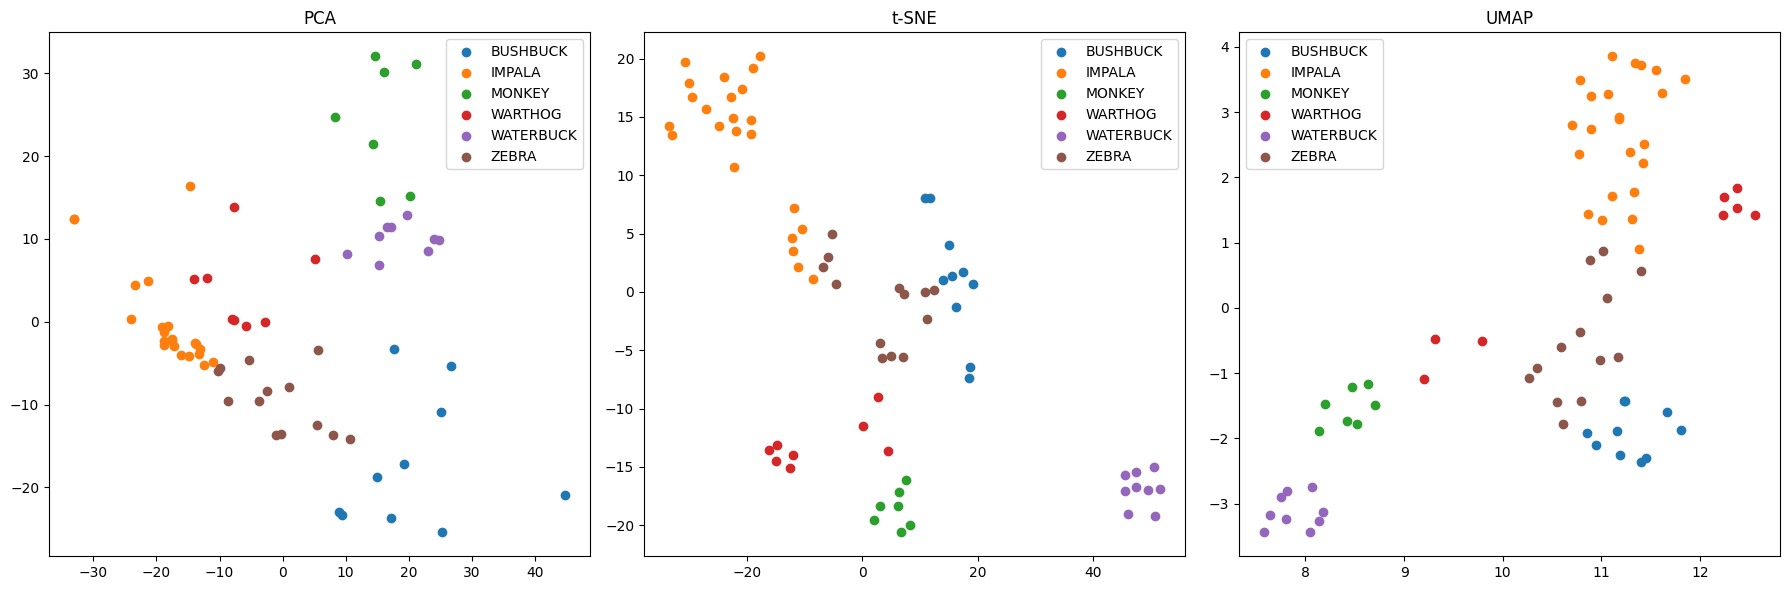

In [4]:
helper.visualize_dimensionality_reduction(val_images, val_labels, labels)


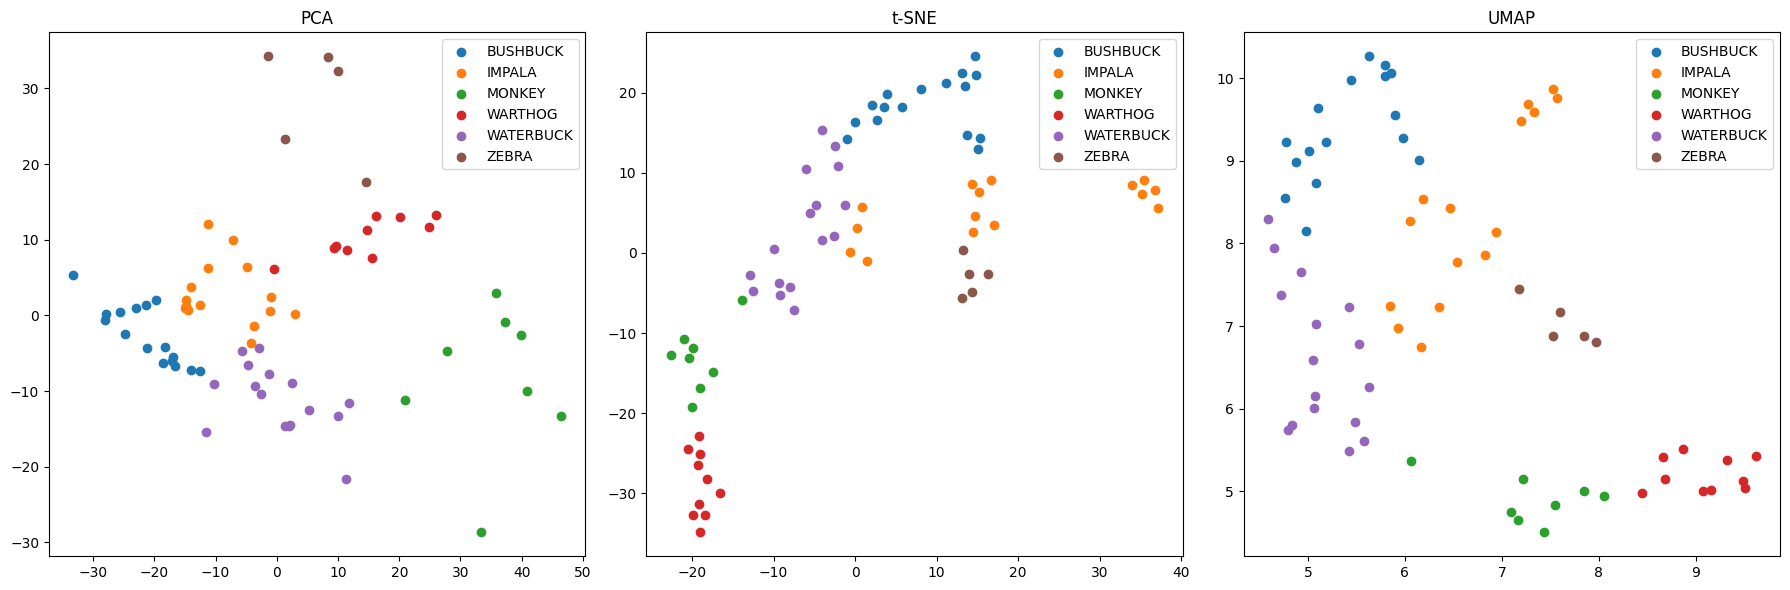

In [105]:
helper.visualize_dimensionality_reduction(val_images, val_labels, labels)


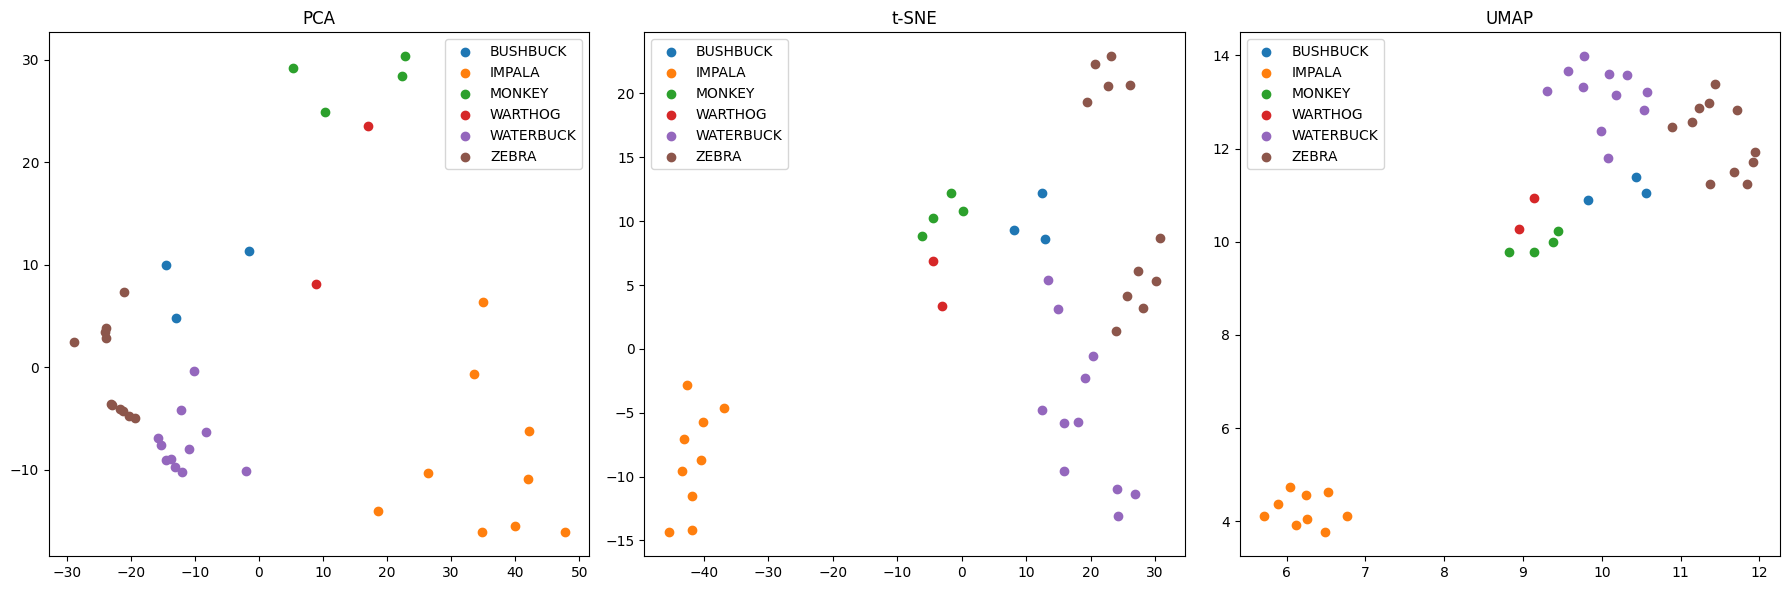

In [4]:
helper.visualize_dimensionality_reduction(test_images, test_labels, labels)


### Model Development

In [ ]:
# Model Architecture leveraging pretrained weights

EPOCHS = 150
LEARNING_RATE = 0.001
NUM_CLASSES = 6
DROP_OUT = 0.1
WEIGHT_DECAY = 0.0005
ACTIVATION = 'softmax'
OPTIMIZER = 'adam'
MOMENTUM = 0.9

model = helper.build_model(num_classes=NUM_CLASSES, drop_out=DROP_OUT, 
                   weight_decay=WEIGHT_DECAY, activation=ACTIVATION, 
                   optimizer=OPTIMIZER, momentum=MOMENTUM)

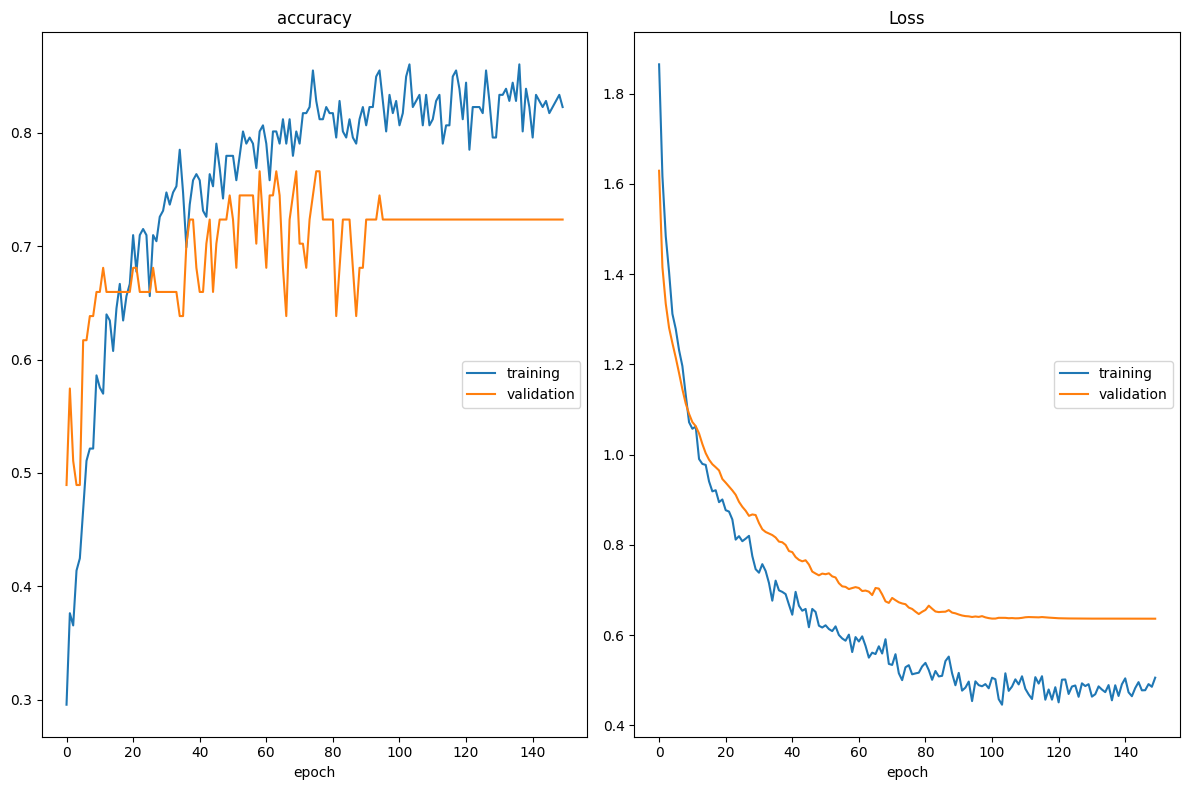

6/6 - 1s - loss: 0.5056 - accuracy: 0.8226 - val_loss: 0.6364 - val_accuracy: 0.7234 - lr: 1.0000e-06 - 1s/epoch - 209ms/step


In [59]:
filepath = 'mobileweights_6classes.h5'
anim = PlotLossesKeras(outputs=[MatplotlibPlot()])

# Define the ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=2)

# Define the learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# Include the lr_scheduler callback in the list of callbacks
callbacks = [checkpoint, anim, lr_scheduler]

# Train the model
history = model.fit(
                  train_images,
                  train_labels,
                  epochs=EPOCHS,
                  validation_data=(val_images, val_labels),
                  verbose=2,
                  callbacks=callbacks
                )


## Model Evaluation

In [152]:
plot_history?

Signature:
plot_history(
    histories: Union[keras.src.callbacks.History, List[keras.src.callbacks.History], Dict[str, List[float]], pandas.core.frame.DataFrame, List[pandas.core.frame.DataFrame], str, List[str]],
    style: str = '-',
    interpolate: bool = False,
    side: float = 5,
    graphs_per_row: int = 4,
    dpi: int = 100,
    customization_callback: Optional[Callable] = None,
    path: Optional[str] = None,
    single_graphs: bool = False,
    max_epochs: Union[int, str] = 'max',
    monitor: Optional[str] = None,
    monitor_mode: str = 'max',
    log_scale_metrics: bool = False,
    show_standard_deviation: bool = False,
    show_average: bool = True,
    title: Optional[str] = None,
    custom_defaults: Optional[Dict[str, Union[List[str], str]]] = None,
) -> Tuple[Union[matplotlib.figure.Figure, List[matplotlib.figure.Figure]], Union[matplotlib.axes._axes.Axes, List[matplotlib.axes._axes.Axes]]]
Docstring:
Plot given training histories.

Parameters
--------------------

(<Figure size 4500x1500 with 3 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

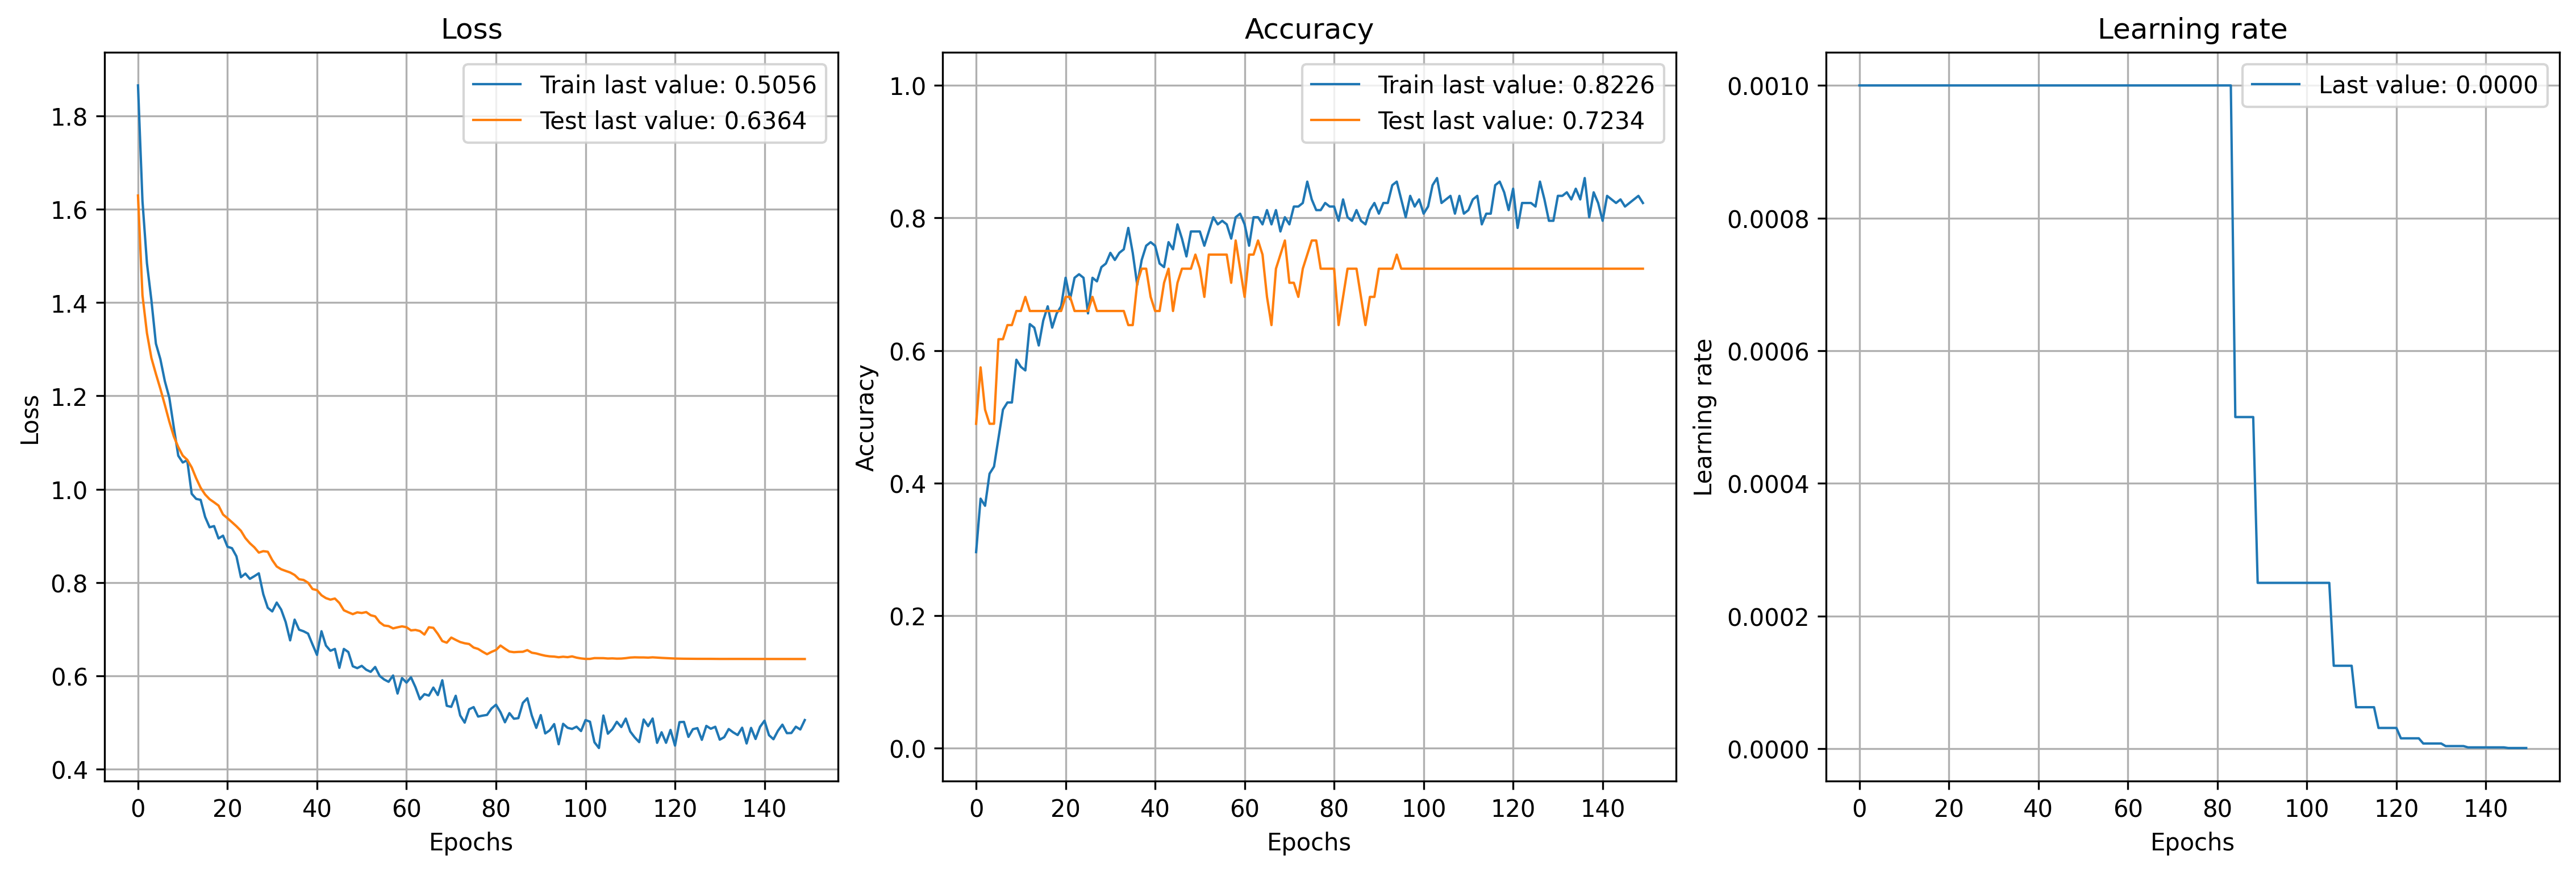

In [153]:
plot_history(history, dpi=300)

In [154]:
test_images, test_labels = helper.extract_images_and_labels(test_tensors, normalize=True, categorical=True)
model = tf.keras.models.load_model('mobileweights_6classes.h5')

model.evaluate(test_images, test_labels)

1/1 [==============================] - 1s 1s/step - loss: 0.9595 - accuracy: 0.5556


[0.9595314860343933, 0.5555555820465088]

In [163]:
from sklearn.metrics import classification_report

test_images, test_labels = helper.extract_images_and_labels(test_tensors, normalize=True, categorical=False)
y_pred = model.predict(test_images, batch_size=6, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_labels, y_pred_bool))

5/5 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.58      0.70      0.64        10
           2       0.00      0.00      0.00         1
           3       0.78      0.88      0.82         8
           4       0.50      0.20      0.29         5
           5       0.67      0.67      0.67         3

    accuracy                           0.63        27
   macro avg       0.42      0.41      0.40        27
weighted avg       0.61      0.63      0.61        27



5/5 [==============================] - 0s 17ms/step


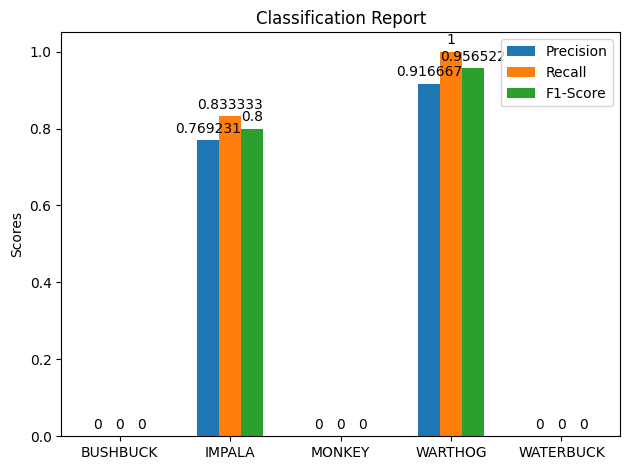

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming you already have these variables defined
test_images, test_labels = helper.extract_images_and_labels(test_tensors, normalize=True, categorical=False)
y_pred = model.predict(test_images, batch_size=6, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# Generate classification report
report = classification_report(test_labels, y_pred_bool, output_dict=True)

# Extract class names and metrics from the report
class_names = [str(label) for label in list(report.keys())[:-3]]  # Exclude 'macro avg', 'weighted avg', etc.
precision = []
recall = []
f1_score = []

for label in class_names:
    try:
        precision.append(report[label]['precision'])
    except KeyError:
        precision.append(0)  # Handle missing precision with a default value
        
    try:
        recall.append(report[label]['recall'])
    except KeyError:
        recall.append(0)  # Handle missing recall with a default value
        
    try:
        f1_score.append(report[label]['f1-score'])
    except KeyError:
        f1_score.append(0)  # Handle missing F1-score with a default value

# Create a bar plot using Matplotlib
x = np.arange(len(class_names))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Classification Report')
ax.set_xticks(x)
ax.set_xticklabels([labels[int(label)] for label in class_names])  # Using custom class labels
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()


## Model Quantization

In [133]:
def representative_dataset_generator():
    for data, _ in val_tensors.take(-1):
        yield [data]  # shape: (batch_size, height, width, channels)


In [135]:
# load the best model
model = tf.keras.models.load_model('mobileweights_6classes.h5')

# quantizing the model to int8
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_generator
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.dtypes.int8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

hub_m = converter.convert()

# save the keras model
with open('mobileweights_6classes.tflite', 'wb') as f:
    f.write(converter.convert())  

INFO:tensorflow:Assets written to: C:\Users\Austin\AppData\Local\Temp\tmp47loco2y\assets


INFO:tensorflow:Assets written to: C:\Users\Austin\AppData\Local\Temp\tmp47loco2y\assets


INFO:tensorflow:Assets written to: C:\Users\Austin\AppData\Local\Temp\tmpan7_3xrg\assets


INFO:tensorflow:Assets written to: C:\Users\Austin\AppData\Local\Temp\tmpan7_3xrg\assets


In [139]:
import edgeimpulse as ei
# add the api key to edge impulse
with open('config.json') as f:
    config = json.load(f)


api_key = config['edge_impulse_api_key']
ei.API_KEY = api_key
    
# the supported devices
profile_devices = ei.model.list_profile_devices()
print(profile_devices)

# target device is open mv cam h7 plus
model_profile = ei.model.profile(model='mobileweights_6classes.tflite', device='arduino-nano-33-ble')

In [140]:
# Profiling the model to check the compatibility with the MCU
model_profile.summary()

Target results for int8:
{
    "device": "arduino-nano-33-ble",
    "tfliteFileSizeBytes": 216920,
    "isSupportedOnMcu": true,
    "memory": {
        "tflite": {
            "ram": 101216,
            "rom": 281200,
            "arenaSize": 100864
        },
        "eon": {
            "ram": 103440,
            "rom": 230424
        }
    },
    "timePerInferenceMs": 710
}


Performance on device types:
{
    "variant": "int8",
    "lowEndMcu": {
        "description": "Estimate for a Cortex-M0+ or similar, running at 40MHz",
        "timePerInferenceMs": 5301,
        "memory": {
            "tflite": {
                "ram": 100435,
                "rom": 266736
            },
            "eon": {
                "ram": 81856,
                "rom": 217496
            }
        },
        "supported": true
    },
    "highEndMcu": {
        "description": "Estimate for a Cortex-M7 or other high-end MCU/DSP, running at 240MHz",
        "timePerInferenceMs": 110,
        "memory":

## Model Deployment

In [142]:
# generating an output file for arduino-nano-33-ble-sense
print('Buuilding firmaware for arduino-nano-33-ble-sense target...')
ei.model.deploy(model='mobileweights_6classes.tflite',
                model_output_type=ei.model.output_type.Classification(),
                model_input_type=ei.model.input_type.ImageInput(),
                deploy_target='arduino-nano-33-ble-sense',
                output_directory=".",
                api_key=api_key)

In [147]:
# Write the class names to text file
with open('labels.txt', 'w') as f:
    for item in list(train_tensors.class_names):
        f.write("%s\n" % item)

In [177]:
# create a folder called openmv-model if it doesn't exist
# move the tflite file and labels.txt file into the openmv-model folder
os.makedirs('openmv-model', exist_ok=True)
os.rename('trained.tflite', 'openmv-model/trained444.tflite')
os.rename('labels.txt', 'openmv-model/labels.txt')